
# Árboles de Decisión

     - Ana Cortazzo 
     - Pablo Schiavone 

# 1. Objetivo

El objetivo de esta tarea es construir un árbol de decisión utilizando el algoritmo ID3 con algunas modificaciones, entrenarlo y evaluarlo sobre el conjunto de datos [*Predict students' dropout and academic success*](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success).

La evaluación del rendimiento del modelo se mide utilizando métricas de evaluación apropiadas para problemas de clasificación, como *accuracy*, *precisión*, *recall*, y *F1-score*.


# 2. Diseño

## 2.1 Análisis exploratorio


En primer lugar se realizó la carga de conjunto de datos y se llevó a cabo un análisis exploratorio inicial con el objetivo de conocer las características de los datos. En particular se analizó:
- Cantidad de instancias, cantidad de atributos y valores faltantes
- Tipo de datos de cada atributo (continuo, discreto, binario)
- Distribución de los datos para cada atributo
- Distribución de los datos en relación al atributo objetivo (**Target**)


En la Tabla 1 se presentan las 10 primeras instancias del conjunto de datos.


In [1]:
# dependencias necesarias para la carga de datos
import requests
from zipfile import ZipFile
from io import BytesIO

# dependencias necesarias para el análsiis
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#dependencias para RF y DT
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn import metrics, tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report


In [2]:
# URL del archivo ZIP
url = 'https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip'
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))

csv_file = zip_file.extract('data.csv')

df = pd.read_csv(csv_file, sep=";", header=0)

print('Tabla 1: Primeras 10 instancias del conjunto de datos')
df.head(10)

Tabla 1: Primeras 10 instancias del conjunto de datos


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
5,2,39,1,9991,0,19,133.1,1,37,37,...,0,5,17,5,11.500000,5,16.2,0.3,-0.92,Graduate
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
7,1,18,4,9254,1,1,119.0,1,37,37,...,0,5,5,0,0.000000,0,15.5,2.8,-4.06,Dropout
8,1,1,3,9238,1,1,137.0,62,1,1,...,0,6,7,6,14.142857,0,16.2,0.3,-0.92,Graduate
9,1,1,1,9238,1,1,138.0,1,1,19,...,0,6,14,2,13.500000,0,8.9,1.4,3.51,Dropout


Se realizó una exploración inicial para conocer la cantidad de valores faltantes y tipo de datos usando el comando


```python
df.info()
```
Los resultados se muestran en la Tabla 2, se observa que no hay valores faltantes.


La Gráfica 1 muestra una visualización de la distribución de los datos por cada atributo. Esta visualización nos permite entender el comportamiento de las variables continuas para definir la mejor estrategia de discretización.





In [3]:
print('Tabla 2: Valores faltantes y tipo de datos')
print(df.info())

Tabla 2: Valores faltantes y tipo de datos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9 

Gráfica 1: Visualización inicial de los datos


/home/anita/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


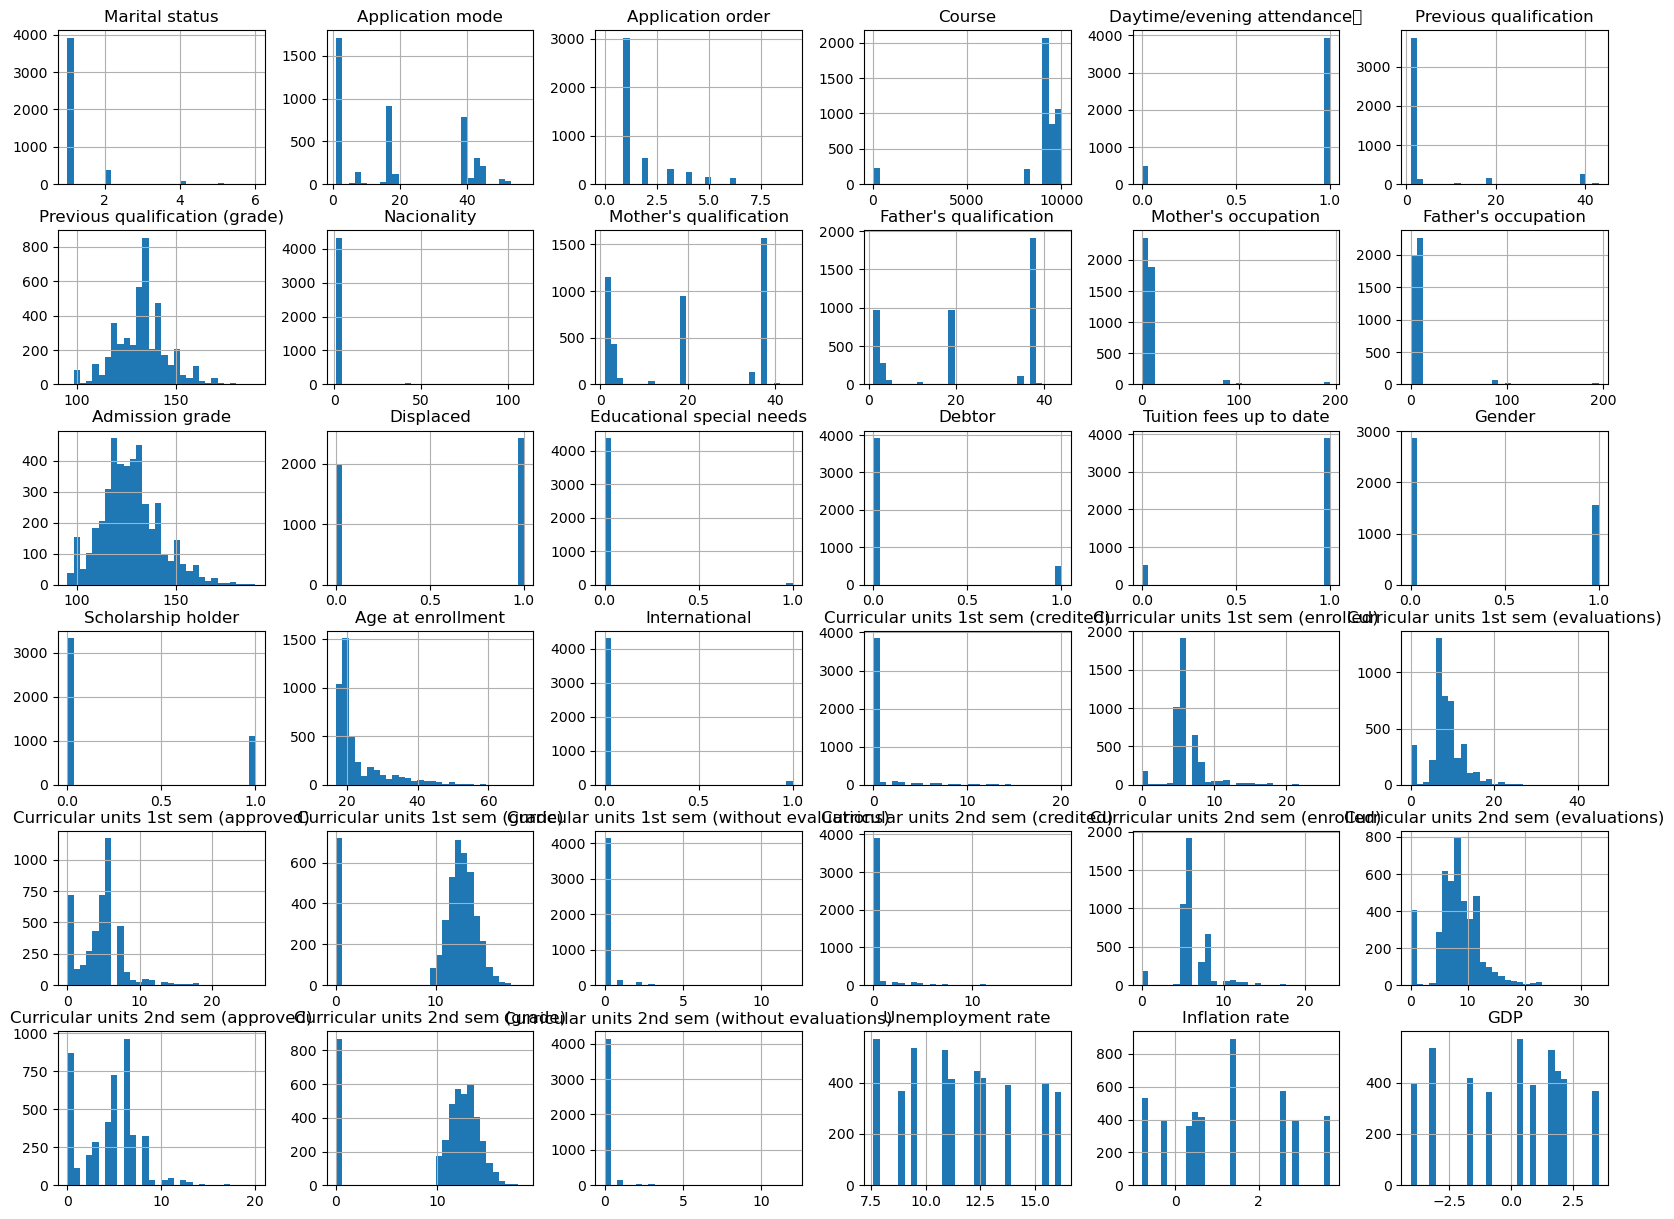

In [4]:
print('Gráfica 1: Visualización inicial de los datos')

hist_plot = df[df.columns].hist(bins=30, figsize=(20, 15))
plt.show()

La distribución de los datos en relación al atributo objetivo se obtuvo mediante un conteo, utilizando
```python
df['Target'].value_counts()
```
Los resultados se presentan en la Tabla 3.


<table>
  <tr>
    <th>Clase</th>
    <th>Cantidad</th>
  </tr>
  <tr>
    <td>Graduate</td>
    <td>2209</td>
  </tr>
  <tr>
    <td>Dropout</td>
    <td>1421</td>
  </tr>
  <tr>
    <td>Enrolled</td>
    <td>794</td>
  </tr>
  <caption>Tabla 3 - Cantidad de instancias por cada clase objetivo</caption>
</table>

## 2.2 Preprocesamiento de datos

### 2.2.1 Discretización de variables


En base al análisis exploratorio se detectó que hay 7 variables de tipo `float64`:
- Previous qualification (grade): entre 0 y 200
- Admission grade: entre 0 y 200
- Curricular units 1st sem (grade): entre 0 y 20
- Curricular units 2nd sem (grade): entre 0 y 20
- Unemployment rate
- Inflation rate
- GDP  


Para discretizar las variables se utilizó `KBinsDiscretizer` de la biblioteca `sklearn.preprocessing`. Los parámetros principales a considerar son:
- `n_bins`: número de agrupamientos a realizar
- `encode`: método utilizado para codificar el resultado transformado
- `strategy`: estrategia utilizada para definir la amplitud de los contenedores


En todos los casos se utilizó `encode=ordinal` ya que los árboles de decisión pueden manejar de forma adecuada las variables numéricas. A partir de la visualización de la distribución de esas variables (Gráfica 1) se seleccionó la mejor estrategia y número de agrupamientos para discretizar cada una de ellas. Se utilizó  `strategy=kmeans` y `n_bins=10` para las variables Previous qualification (grade), Admission grade, Curricular units 1st sem (grade) y Curricular units 2nd sem (grade), ya que la distribución de las variables se asemeja a la distribución normal, y `strategy=uniform` y `n_bins=5` para las variables Unemployment rate, Inflation rate y GDP








In [5]:
columnas = ['Previous qualification (grade)', 'Admission grade',
            'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

# Aplicar la discretización a las columnas seleccionadas
discretized_data = est.fit_transform(df[columnas])
# Convertir los datos discretizados a int64
discretized_data = discretized_data.astype(int)

df_1 = df
# Reemplazar las columnas originales con las columnas discretizadas
df_1[columnas] = discretized_data

In [6]:
columnas = ['Unemployment rate', 'Inflation rate', 'GDP']

est2 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Aplicar la discretización a las columnas seleccionadas
discretized_data = est2.fit_transform(df[columnas])
# Convertir los datos discretizados a int64
discretized_data = discretized_data.astype(int)

# Reemplazar las columnas originales con las columnas discretizadas
df_1[columnas] = discretized_data

### 2.2.2 Binarización de variable Target


La Tabla 3 sistematiza los valores por cada clase de la variable **Target**, que en el conjunto de datos original puede tomar tres valores posibles: *dropout*, *enrolled*, y *graduate*. En este trabajo los valores *enrolled* y *graduate* serán considerados como uno solo, asignándole el valor `si`, y a *dropout* se le asigna el valor `no`.


La Tabla 4 muestra el conjunto de datos después del procesamiento.



In [7]:
df_1['Target'] = df_1['Target'].replace({'Dropout': 'no', 'Enrolled': 'si', 'Graduate': 'si'})
print('Tabla 4: Primeras 5 instancias del conjunto de datos luego del procesamiento')
df_1.head(5)

Tabla 4: Primeras 5 instancias del conjunto de datos luego del procesamiento


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,2,1,19,12,...,0,0,0,0,0,0,1,2,3,no
1,1,15,1,9254,1,1,6,1,1,3,...,0,6,6,6,5,0,3,0,3,si
2,1,1,5,9070,1,1,2,1,37,37,...,0,6,0,0,0,0,1,2,3,no
3,1,17,2,9773,1,1,2,1,38,37,...,0,6,10,5,3,0,1,0,0,si
4,2,39,1,8014,0,1,0,1,37,38,...,0,6,6,6,4,0,3,0,3,si


Finalmente, la cantidad de instancias por cada clase después del procesamiento de los datos se muestra en la Tabla 5.
<table>
  <tr>
    <th>Clase</th>
    <th>Cantidad</th>
  </tr>
  <tr>
    <td>si</td>
    <td>3003</td>
  </tr>
  <tr>
    <td>no</td>
    <td>1421</td>
  </tr>

  <caption>Tabla 5 - Cantidad de instancias por cada clase objetivo luego del procesamiento</caption>
</table>

## 2.3 Algoritmo

El algoritmo ID3 (*Iterative Dichotomiser 3*) es un método de aprendizaje automático utilizado para construir árboles de decisión que se utilizan en tareas de clasificación. En este trabajo se realiza una modificación del algoritmo original, agregando los hiperparámetros `min_samples_split` y `min_split_gain` que nos permiten ajustar la construcción del árbol de decisión.

- `min_samples_split` define la cantidad mínima de ejemplos necesarios para crear un nuevo nodo, lo que evita la formación de nodos con muy pocos ejemplos.

- `min_split_gain` establece la ganancia mínima requerida para que un atributo divida el conjunto de datos, lo que garantiza que las divisiones sean significativas.


El algoritmo que se presenta en  este trabajo se puede explicar de forma simplificada como sigue:

- Inicio
  - Inicializa un nodo raíz del árbol.
- Selección del Mejor Atributo
  - Calcula la ganancia de información para cada atributo en el conjunto de datos en función de la entropía de las etiquetas.
  - Compara la ganancia de información con `min_split_gain`. Si no se cumple esta condición, se crea un nodo hoja con la etiqueta mayoritaria y se termina la construcción de ese subárbol. Si se cumple pasa a la creación de nodos hijos.
- Creación de Nodos Hijos
  - Para cada valor único del atributo seleccionado en el paso anterior, verifica si el número de ejemplos es mayor o igual a `min_samples_split`. Si es cierto, crea un nodo hijo correspondiente en el árbol y divide el conjunto de datos en subconjuntos según los valores del atributo seleccionado. Si no se cumple esta condición, crea un nodo hoja con la etiqueta mayoritaria.
  - Si todos los ejemplos en un subconjunto tienen la misma etiqueta, crea un nodo hoja con esa etiqueta.
  - Si no quedan atributos para dividir o el número de ejemplos es menor que `min_samples_split`, crea un nodo hoja con la etiqueta mayoritaria en el subconjunto actual.
- Recursividad
  - Si no se cumple ninguna de las condiciones de corte, repite los pasos anteriores para cada nodo hijo.

La implementación del algoritmo se presenta a continuación:




In [8]:
class Nodo:
    def __init__(self, nombre, padre, instancia_mayoritaria, arista):
        self.nombre = nombre
        self.padre = padre
        self.arista = arista
        self.instancia_mayoritaria=instancia_mayoritaria
        self.hijos = []

    def addHijo(self, hijo):
        self.hijos.append(hijo)

    def retornarHijo(self, arista):
      for hijo in self.hijos:
        if hijo.arista == arista:
          return hijo
      return None

In [9]:
class ID3:

#Se inicializan dos atributos de la instancia: raiz y atributos.
	def __init__(self):
		self.raiz        = None
		self.atributos   = None

#crear un nuevo objeto Nodo. Recibe tres argumentos: nombre que representa el nombre del nodo
	def crear_nodo(self, nombre, padre, instancia_mayoritaria, arista=None):
		return Nodo(nombre, padre, instancia_mayoritaria,  arista)

#Recibe una lista de atributos y los asigna al atributo self.atributos.
	def establecer_atributos(self, atributos):
		self.atributos = atributos

#indntifico la instancia mayoritaria - sirve para decidir etiqueta (target=y)
	def instancia_mayoritaria(self, target):
		cuenta = target.value_counts()
		instancia_mayoritaria = cuenta.idxmax()
		return instancia_mayoritaria

#entropia total del conjunto de datos (target=y)
	def calcularEntropia(self, target):
		entropia = 0
		valores_distintos = target.unique()
		for valor in valores_distintos:
			probability = sum(target == valor) / len(target)
			if probability != 0:
				entropia -= probability * math.log2(probability)
		return entropia

#entropia de cada atributo  (df=X , target=y)
	def calcularEntropiaAtributo(self, df, target, atributo):
		entropia_atributo = 0
		col_atributo = df[atributo]
		valores_distintos = col_atributo.unique()
		for valor in valores_distintos:
			dfA = col_atributo[col_atributo == valor]
			proporcion = len(dfA) / len(target)
			target_subset = target[dfA.index]
			entropia_atributo += self.calcularEntropia(target_subset) * proporcion
		return entropia_atributo

#ganancia por atributo (target=y)
	def calcularGanancia(self, df, target, atributo):
		return self.calcularEntropia(target) - self.calcularEntropiaAtributo(df, target, atributo)

# seleccionar el mejor atributo en base a la ganancia, ya no considera los atributos pasados
	def mejor_atributo(self, df, target, anteriores):
		ganancia = []
		atributos = list(df.columns)
		for atributo in atributos:
			if atributo not in anteriores:
				ganancia.append(self.calcularGanancia(df, target, atributo))
			else:
				ganancia.append(float("-inf"))
		return ganancia.index(max(ganancia))


# creo hijos, función recurisiva. tengo 4 puntos de corte:
# 1- ya no tengo más atributos
# 2- todas las instancias pertenecen a la misma clase
# 3- me quedan menos instancias que min_sample_split
# 4- la ganancia del atributo no alcanza el mínimo
# en todos los demás caso continúo creando hijos

	def crearHijo(self, df, target, atributo, anteriores, nodo_actual, min_sample_split, min_split_gain):
		#accedo a los datos del atributo
		col_atributo = df[atributo]
		valores =  col_atributo.unique().tolist()

		# condición ganancia mínima del atributo
		#verifico min_split_gain
		if (self.calcularGanancia(df, target, atributo) > min_split_gain) and  len(df) > min_sample_split:
			#itera a través de cada valor único en la columna del atributo actual
			for valor in valores:
				x = df[col_atributo == valor]
				y = target[col_atributo == valor]

				# condición: verifico condición min_sample_split
				if len(x) < min_sample_split:
					instancia = self.instancia_mayoritaria(y) #agrego la etiqueta hoja
					hijo = self.crear_nodo(instancia, nodo_actual,instancia, valor)
					nodo_actual.addHijo(hijo)

				# verifico si nos quedamos sin atributos.
				if len(anteriores) == df.shape[1]:
					instancia = self.instancia_mayoritaria(y) #agrego la etiqueta
					hijo      = self.crear_nodo(instancia, nodo_actual,instancia, valor)
					nodo_actual.addHijo(hijo)

				# condición Verificar si todas las instancias son iguales en el atributo.
				if len(y.unique()) == 1: #hay una sola instancia
					instancia = y.iloc[0] #etiqueto con esa instancia
					hijo = self.crear_nodo(instancia, nodo_actual,instancia, valor)
					nodo_actual.addHijo(hijo)

				# Si no corta en ningún if, continuar creando hijos recursivamente
				else:
					mejor_atributo = self.mejor_atributo(x, y, anteriores)
					instancia = self.instancia_mayoritaria(y) #agrego la etiqueta
					nombre_hijo = self.atributos[mejor_atributo]
					nodo_hijo = self.crear_nodo(nombre_hijo, nodo_actual,instancia, valor)
					nodo_actual.addHijo(nodo_hijo)
					self.crearHijo(x, y, nombre_hijo, anteriores + [mejor_atributo], nodo_hijo, min_sample_split, min_split_gain)

		else:  # Si la ganancia es menor que min_split_gain, crear nodo hoja con instancia mayoritaria
			instancia_mayoritaria = self.instancia_mayoritaria(target)
			hijo = self.crear_nodo(instancia_mayoritaria, nodo_actual, instancia_mayoritaria)
			nodo_actual.addHijo(hijo)

	def crearArbol(self, df, target, min_samples_split, min_split_gain):
		anteriores = []
		mejor = self.mejor_atributo(df, target, anteriores)
		atributo_best = self.atributos[mejor]
		self.raiz = self.crear_nodo(atributo_best, None, atributo_best)
		anteriores.append(mejor)
		self.crearHijo(df, target, atributo_best, anteriores, self.raiz, min_samples_split, min_split_gain)


	def entrenar(self, df, target, min_samples_split, min_split_gain):
		# Establecemos etiquetas
		if self.atributos is None:
			self.atributos = df.columns
		#creo árbol
		self.crearArbol(df, target, min_samples_split, min_split_gain)

	def predecir_instancia(self, instancia):
		nodo_actual = self.raiz
		while nodo_actual.hijos:
			atributo = nodo_actual.nombre
			col_atributo = self.atributos.get_loc(atributo)
			valor_atr = instancia[col_atributo]
			#nodo_actual = nodo_actual.retornarHijo(valor_atr)
			siguiente_nodo = nodo_actual.retornarHijo(valor_atr)
			if siguiente_nodo is None:
      # Si no encuntra un hijo etiquetado con ese valor de atributo se devuelve la instancia mayor
				return  nodo_actual.instancia_mayoritaria
			nodo_actual = siguiente_nodo
		return nodo_actual.nombre  # Devuelve la etiqueta del nodo hoja

	def predecir(self, df):
			Y = pd.Series(index=df.index, dtype="<U10")

			for idx, fila in df.iterrows():
				Y[idx] = self.predecir_instancia(fila)
			return Y

## 2.4 Evaluación



Para evaluar la calidad de los modelos de clasificación entrenados se utilizaron los siguientes parámetros:

- **Accuracy** (acierto): Es la proporción de instancias clasificadas correctamente sobre el total de instancias. Sea $V_p$ y $V_n$ los verdaderos positivos y negativos y $F_p$ y $F_n$ los falsos positivos y negativos respectivamente, se puede calcular el accuracy como:
  $$ acc = \frac{V_p + V_n}{V_p + V_n + F_p + F_n}$$

  El código implementado para calcular el acierto es:


```python
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)
```



- **Precision** (Precisión): Es la proporción de instancias clasificadas correctamente como positivas (verdaderos positivos) sobre el total de instancias clasificadas como positivas (verdaderos positivos más falsos positivos). Cuanto mayor sea la precisión, mejor será el modelo en la identificación de instancias positivas de manera precisa.
  $$ precision = \frac{V_p}{V_p + F_p}$$

- **Recall**: Es la proporción de instancias positivas clasificadas correctamente (verdaderos positivos) sobre el total de instancias positivas (verdaderos positivos más falsos negativos).
  $$recall = \frac{V_p }{V_p + F_n}$$

- **F1-score** (medida-F): Es la media armónica entre precisión y recall, e intenta combinar ambas en un solo número. Se determina mediante:
  $$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$

- **Matriz de confusión**: Una matriz cuadrada que muestra el número de instancias clasificadas correctamente e incorrectamente para cada clase. Las filas contienen información sobre el valor verdadero y las columnas el valor predicho por el modelo. La diagonal muestra las predicciones correctas.

- **Curva ROC** (Receiver Operating Characteristic): muestra la relación entre la tasa de verdaderos positivos (True Positive Rate, TPR) y la tasa de falsos positivos (False Positive Rate, FPR) en diferentes umbrales de decisión.

  - Tasa de Verdaderos Positivos (TPR): También conocida como Sensibilidad o Recall.
  - Tasa de Falsos Positivos (FPR): Es la proporción de casos negativos que el modelo clasifica incorrectamente como positivos. Se calcula como:
  $$ FPR = \frac{F_p}{V_n + F_p}$$
  - Área Bajo la Curva (AUC): La AUC representa el área bajo la curva ROC. Es un valor numérico que proporciona una medida de la capacidad del modelo para distinguir entre las clases positiva y negativa. Una AUC = 0.5 indica un comportamiento aleatorio, y una AUC=1 indica un comportamiento ideal. Cuanto mayor sea el valor de AUC, mejor será el rendimiento del modelo.


Para el cálculo de las demás métricas de evaluación, la obtención de la matriz de confusión y la curva ROC se utilizó `classification_report`, `confusion_matrix`, `roc_curve` y `roc_auc_score` de `sklearn.metrics`


# 3. Experimentación

La experimentación de divide en tres secciones:
- **Algoritmo ID3** dónde se presenta la división de conjunto de datos en los subconjuntos de entrenamiento (*train*) y  evaluación (*test*), la selección de los hiperparámetros óptimos y finalmente la evaluación del algoritmo
- **DecisionTreeClassifier y RandomForestClassifier** donde se presenta la selección de hiperparámetros, entrenamiento y evaluación de los modelos.
- **Comparación de resultados**


## 3.1 Algoritmo ID3



In [11]:
###Funciones auxiliares

def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

def plotROC(titulo, y_test,y_pred ):
  y_test_b = [1 if elemento == "si" else 0 for elemento in y_test]
  y_pred_b = [1 if elemento == "si" else 0 for elemento in y_pred]

  # Calcula la Curva ROC
  fpr, tpr, thresholds = roc_curve(y_test_b, y_pred_b)

  # Calcula el AUC
  roc_auc = roc_auc_score(y_test_b, y_pred_b)

  # Grafica la Curva ROC
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', alpha=0.5, lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(titulo)
  plt.legend(loc='lower right')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.xticks(np.arange(0, 1.1, 0.1))
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.show()

#graficar matriz de confusión
def cm_plot(titulo,y_test, y_pred ):
   cm = confusion_matrix(y_test, y_pred)
   cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[ "No", "Si",])
   cm_display.plot()
   cm_display.ax_.set_title(titulo)


**Definición de conjuntos *train/test***

En primer lugar se separó el conjunto de datos preprocesado (`df_1`) en dos subconjuntos:
- `X`: conteniendo todos los atributos menos el atributo objetivo
- `y` : el atributo objetivo (`Target`)

A partir de estos se asigna 80% al subconjunto de entrenamiento y 20% al subconjunto de evaluación estratificado, es decir, manteniendo la proporción del muestreo entre las clases. La división se realiza utilizando `train_test_split` de `sklearn.model_selection`.

In [12]:
X = df_1.drop("Target", axis=1)
y = df_1["Target"]

#### Separo los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,  random_state = 42)
print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

Tamaños de Train/Test: 3539/885


### 3.2.1 Selección de hiperparámetros óptimos

Previo al entrenamiento del algoritmo ID3 se utilió la técnica de validación cruzada (*cross validation*) para seleccionar los mejores hiperparámetros (en este caso `min_sample_split` y `min_split_gain`) para el modelo.

La técnica de validación cruzada consiste en dividir el conjunto de datos de entrenamiento en *k* partes, luego se utilizan *k-1* partes para entrenar, y la restante para evaluar el modelo, sin necesidad de usar los datos de evaluación en esta etapa. Se puede seleccionar el valor de *k* adecuado para subdividir los datos. En este caso se fijó *k=4* y un conjunto de 6 parámetros que varían los valores de `min_sample_split` y `min_split_gain`.


In [13]:
### declaro arbol ID3
arbol = ID3()

In [14]:
#Validación cruzada

#Parametros para dividir el dataset de entrenamiento
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
param_sets = [{"min_samples_split": 100, "min_split_gain": 0.1},
              {"min_samples_split": 100, "min_split_gain": 0.2},
              {"min_samples_split": 200, "min_split_gain": 0.1},
              {"min_samples_split": 200, "min_split_gain": 0.2},
              {"min_samples_split": 500, "min_split_gain": 0.1},
              {"min_samples_split": 500, "min_split_gain": 0.2}]
X_dev = X_train
y_dev = y_train

viol = []
for params in param_sets:
  lista = []
  for train_idxs, val_idxs in skf.split(X_dev, y_dev):
  # Train y validation para el split actual
    X_train_ = X_dev.iloc[train_idxs]
    y_train_ = y_dev.iloc[train_idxs]
    X_val = X_dev.iloc[val_idxs]
    y_val = y_dev.iloc[val_idxs]
    arbol=None
    arbol = ID3()
    arbol.entrenar(X_train, y_train, params["min_samples_split"], params["min_split_gain"])
    # Predecimos y evaluamos en Validation
    y_pred_val = arbol.predecir(X_val)
    acc = get_accuracy(y_val, y_pred_val)
    lista.append(acc)
    print(f"{acc=:.4f} {params=}")
  viol.append(lista)

acc=0.8610 params={'min_samples_split': 100, 'min_split_gain': 0.1}
acc=0.8452 params={'min_samples_split': 100, 'min_split_gain': 0.1}
acc=0.8678 params={'min_samples_split': 100, 'min_split_gain': 0.1}
acc=0.8609 params={'min_samples_split': 100, 'min_split_gain': 0.1}
acc=0.8350 params={'min_samples_split': 100, 'min_split_gain': 0.2}
acc=0.8407 params={'min_samples_split': 100, 'min_split_gain': 0.2}
acc=0.8362 params={'min_samples_split': 100, 'min_split_gain': 0.2}
acc=0.8439 params={'min_samples_split': 100, 'min_split_gain': 0.2}
acc=0.8463 params={'min_samples_split': 200, 'min_split_gain': 0.1}
acc=0.8418 params={'min_samples_split': 200, 'min_split_gain': 0.1}
acc=0.8542 params={'min_samples_split': 200, 'min_split_gain': 0.1}
acc=0.8552 params={'min_samples_split': 200, 'min_split_gain': 0.1}
acc=0.8350 params={'min_samples_split': 200, 'min_split_gain': 0.2}
acc=0.8407 params={'min_samples_split': 200, 'min_split_gain': 0.2}
acc=0.8362 params={'min_samples_split': 200, 'mi

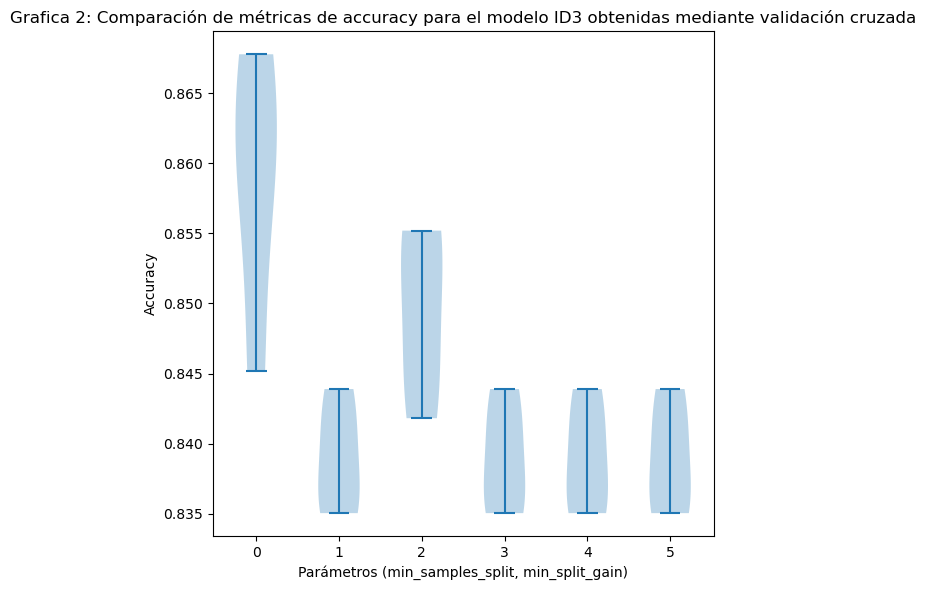

In [15]:
positions = np.arange(0, len(viol),1)
fig, ax = plt.subplots(figsize=(6, 6))
ax.violinplot(viol, positions=positions)
#ax.set_xticklabels(["Si","No"]) #Tengo que arreglar esto
ax.set_title("Grafica 2: Comparación de métricas de accuracy para el modelo ID3 obtenidas mediante validación cruzada")
ax.set_xlabel("Parámetros (min_samples_split, min_split_gain)")
ax.set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

La Gráfica 2  muestra la variabilidad del valor de *accuracy* en cada uno de los modelos entrenados (del 0 al 5) en todos los splits realizados (en este caso 4).

Se puede observar que el modelo 0 (correspondiente a `min_samples_split`: 100, `min_split_gain`: 0.1) presenta el mejor valor de *accuracy* promedio aunque muestre la mayor variabilidad entre splits, mientras que los modelos 1, 3, 4 y 5 tienen los valores medios de *accuracy* más bajos.

Cuando `min_samples_split`=100 se observa una variación en el valor de *accuracy* dada por la variación de parámetro  `min_split_gain` de 0.1 a 0.2 (en el gráfico corresponde a 0 y 1), también se observa esa variación cuando `min_samples_split`=200. Esto nos dice que si el valor de ganancia mínimo requerido para partir por atributo es mayor, el modelo pierde poder de acierto.

Cuando  `min_samples_split`=500, las variaciones de `min_split_gain` no afectan el valor de *accuracy*, es decir, el corte en el algoritmo se da antes de verificar la ganancia, porque la cantidad de ejemplos requerida es un valor alto, y muchos atributos no alcanzan este umbral.




### 3.2.2 Evaluación del algoritmo ID3

Se entrena el modelo ID3 con los hiperparámetros óptimos obtenidos mediante validación cruzada. Luego del entrenamiento se evalúa utilizando en conjunto de test.

La Tabla 6 muestra las métricas de evaluación obtenidas para el modelo ID3, se obtuvo un valor de accuracy de 0,84 y una precisión alta para las dos clases. Si observamos el valor de recall se puede observar que el modelo tiene un buen rendimiento en la predicción de instancias `si` y un rendimiento menor en la predicción de instancias `no`.

En casos de desbalance de datos, donde una clase tiene muchas más instancias que otras (en este caso la clase `si` tiene mayor número de instancias) el modelo puede tener un sesgo hacia la clase mayoritaria, es decir que tiende a predecir con mayor frecuencia la clase mayoritaria. Si solo observamos el valor de accuracy, este podría dar una percepción poco acertada sobre el comportamiento del modelo, ya que puede mostrar una alta tasa de acierto general debido al alto número de predicciones correctas para la clase mayoritaria, pero ocultar un rendimiento bajo en la clasificación de las clases minoritarias, que se pueden observar mirando la precisión y recall.


In [16]:
arbol.entrenar(X_train, y_train, 100, 0.1)

In [17]:
y_pred_ID3=arbol.predecir(X_test)
target_names = ["No", "Si"]
print('Tabla 6: Métricas de evaluación obtenidas para el modelo ID3')
print(classification_report(y_test, y_pred_ID3, target_names=target_names))
metricsID3 = metrics.classification_report(y_test, y_pred_ID3, output_dict=True)

Tabla 6: Métricas de evaluación obtenidas para el modelo ID3
              precision    recall  f1-score   support

          No       0.85      0.60      0.70       284
          Si       0.83      0.95      0.89       601

    accuracy                           0.84       885
   macro avg       0.84      0.78      0.80       885
weighted avg       0.84      0.84      0.83       885



En la Gráfica 3 se presenta la matriz de confusión. A partir de la diagonal de la matriz obtenemos el accuracy del modelo, ya que en la diagonal se muestran las instancias verdaderas, es decir, las que fueron clasificadas correctamente. La precisión para cada clase también puede obtenerse a partir de la matriz, en este caso observando las columnas que muestran el total de instancias clasificadas como positivas, y las filas de la matriz muestran el total de instancias positivas y nos dan la información de recall.

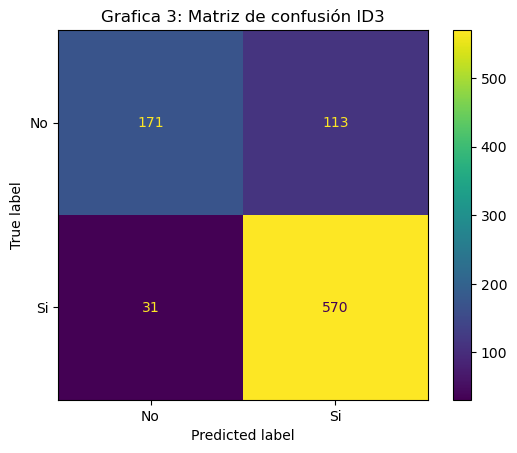

In [18]:
cm_plot("Grafica 3: Matriz de confusión ID3", y_test, y_pred_ID3)

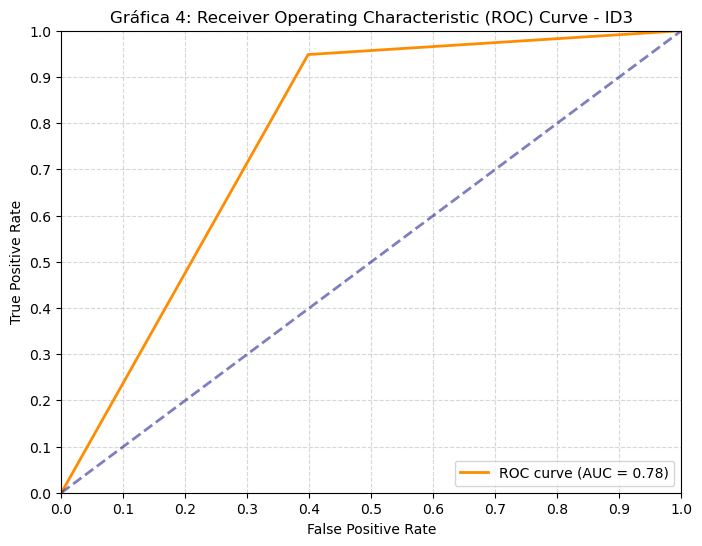

In [19]:
plotROC("Gráfica 4: Receiver Operating Characteristic (ROC) Curve - ID3",y_test,y_pred_ID3)

La Gráfica 4 presenta la curva ROC para el ID3. Se observa una línea recta de pendiente pronunciada desde el origen hasta el valor de FPR de 0,4 aproximadamente. Esta parte de la curva indica que el modelo tiene un excelente rendimiento en términos de Tasa de Verdaderos Positivos (TPR) en relación con la Tasa de Falsos Positivos (FPR). A medida que aumenta el umbral de decisión, la TPR aumenta rápidamente mientras que la FPR se mantiene baja, lo que indica que el modelo está identificando correctamente muchas instancias positivas y minimizando los falsos positivos. El segundo tramo de la curva muestra que a medida que aumenta el umbral de decisión, la TPR sigue aumentando, pero a costa de un aumento en la FPR. El valor del AUC  = 0.78 indica que, en general, el modelo tiene un buen poder de discriminación entre las clases positivas y negativas.


## 3.3 *DecisionTreeClassifier* y *RandomForestClassifier*

Para los modelos pertenecientes a la librería `scikit-learn` (*DecisionTreeClassifier*, *RandomForestClassifier*) se seleccionaron los mejores hiperparámetros utilizando `GridSearchCV`.

### 3.3.1 *DecisionTreeClassifier*

Previo al entrenamiento del modelo *DecisionTreeClassifier* utilizó validación cruzada para seleccionar el valor óptimo de los siguientes hiperparámetros:
- `min_samples_split`: número mínimo de muestras requeridas para dividir un nodo interno
- `min_samples_leaf`: número mínimo de muestras requeridas para estar en un nodo de hoja.
- `min_impurity_decrease`: un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual a este valor.

In [20]:
# Definir el modelo de DecisionTree
model = tree.DecisionTreeClassifier()

# Definir los hiperparámetros y los rangos a probar
param_grid = {
    'min_impurity_decrease': np.arange(0, 0.3, 0.01),  # Impureza mínima requerida para crear un nodo
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en cada hoja
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=4)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
accuracy = best_model.score(X_test, y_test)
print("Exactitud del mejor modelo:", accuracy)

Mejores hiperparámetros: {'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 2}
Exactitud del mejor modelo: 0.8531073446327684


In [21]:
clasificadorDT = tree.DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01 , min_samples_leaf=1, min_samples_split=2)
desTree_clf = clasificadorDT.fit(X_train, y_train)
y_test_pred_DT = desTree_clf.predict(X_test)

Luego se entrenó el modelo con los parámetros óptimos utilizando el mismo conjunto de entrenamiento (`X_train`) y se realizó la predicción sobre el conjunto de evaluación. La Tabla 7 muestra las métricas de evaluación obtenidas, dónde nuevamente se observa una diferencia en el valor de recall para las clases.

In [22]:
print('Tabla 7: Métricas de evaluación obtenidas para el modelo Decision Tree')
print(classification_report(y_test, y_test_pred_DT, target_names=target_names))
metricsDT = metrics.classification_report(y_test, y_test_pred_DT, output_dict=True)

Tabla 7: Métricas de evaluación obtenidas para el modelo Decision Tree
              precision    recall  f1-score   support

          No       0.87      0.64      0.74       284
          Si       0.85      0.96      0.90       601

    accuracy                           0.85       885
   macro avg       0.86      0.80      0.82       885
weighted avg       0.86      0.85      0.85       885



La Gráfica 5 presenta la matriz de confusión  y la Gráfica 6 presenta la curva ROC para el modelo  *DecisionTreeClassifier*. El valor del AUC  = 0.8 indica que, en general, el modelo tiene un buen poder de discriminación entre las clases positivas y negativas.

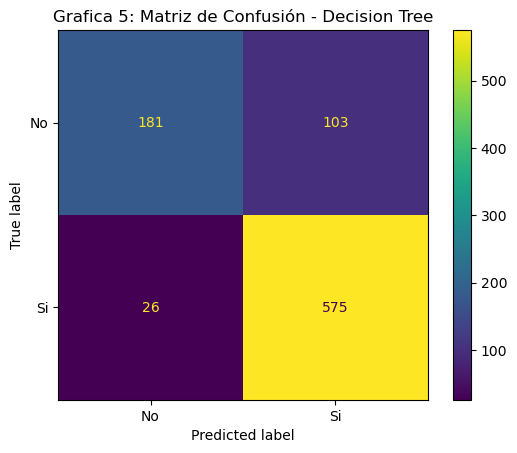

In [23]:
cm_plot("Grafica 5: Matriz de Confusión - Decision Tree", y_test, y_test_pred_DT)

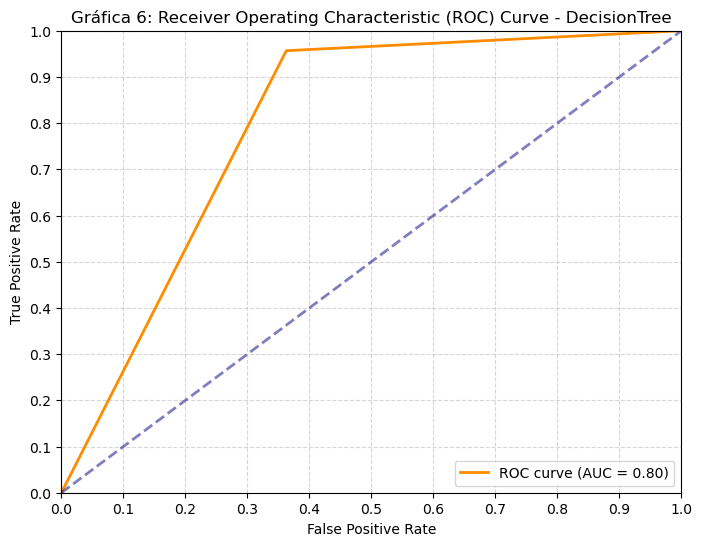

In [24]:
plotROC("Gráfica 6: Receiver Operating Characteristic (ROC) Curve - DecisionTree", y_test,y_test_pred_DT )

### 3.3.2 *RandomForestClassifier*

Previo al entrenamiento del modelo *RandomForestClassifier* utilizó validación cruzada para seleccionar el valor óptimo de los siguientes hiperparámetros:
- `n_estimators`: número de árboles en el bosque
- `max_features`: la cantidad de características que se consideran al buscar la mejor forma de dividir un nodo
- `bootstrap`: Si se utilizan muestras bootstrap al construir los árboles. Si es False, se utiliza todo el conjunto de datos para construir cada árbol.

In [25]:
model = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': [None, 'sqrt', 'log2', 0.1, 0.5],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=4)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
accuracy = best_model.score(X_test, y_test)
print("Mejor exactitud del modelo:", accuracy)

Mejores hiperparámetros: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 150}
Mejor exactitud del modelo: 0.8779661016949153


In [26]:
clasificadorRF = RandomForestClassifier(n_estimators=150, random_state=42, criterion='entropy', bootstrap=True, max_features='sqrt')
ranForest_clf = clasificadorRF.fit(X_train, y_train)
y_test_pred_RF = ranForest_clf.predict(X_test)

Luego se entrenó el modelo con los parámetros óptimos utilizando el mismo conjunto de entrenamiento (`X_train`) y se realizó la predicción sobre el conjunto de evaluación. La Tabla 8 muestra las métricas de evaluación obtenidas, dónde nuevamente se observa una diferencia en el valor de recall para las clases.

La Gráfica 7 presenta la matriz de confusión  y la Gráfica 8 presenta la curva ROC para el modelo  *RandomForestClassifier*. El valor del AUC  = 0.83 indica que, en general, el modelo tiene un buen poder de discriminación entre las clases positivas y negativas.

In [27]:
print('Tabla 8: Métricas de evaluación obtenidas para el modelo Random Forest')
print(metrics.classification_report(y_test, y_test_pred_RF))
metricsRF = metrics.classification_report(y_test, y_test_pred_RF, output_dict=True)

Tabla 8: Métricas de evaluación obtenidas para el modelo Random Forest
              precision    recall  f1-score   support

          no       0.88      0.70      0.78       284
          si       0.87      0.95      0.91       601

    accuracy                           0.87       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.87      0.87      0.87       885



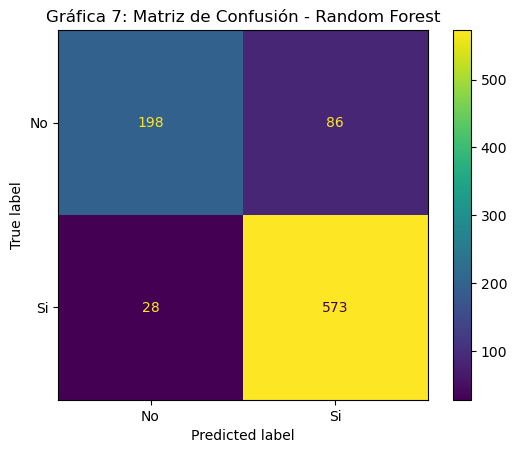

In [28]:
cm_plot("Gráfica 7: Matriz de Confusión - Random Forest", y_test, y_test_pred_RF)

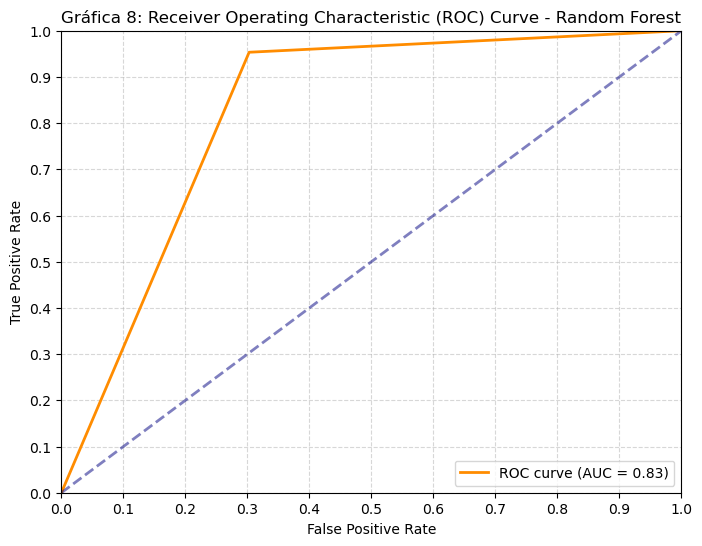

In [29]:
plotROC("Gráfica 8: Receiver Operating Characteristic (ROC) Curve - Random Forest", y_test,y_test_pred_RF )

## 3.4 Comparación de resultados

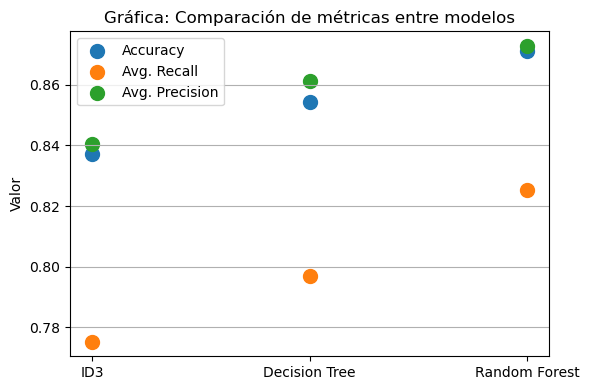

In [30]:
# Obtener las métricas para cada modelo
metrics_models = {
    'ID3': metricsID3,
    'Decision Tree': metricsDT,
    'Random Forest': metricsRF}

accuracy_values = [metrics_models[model]['accuracy'] for model in metrics_models]
recall_values = [metrics_models[model]['macro avg']['recall'] for model in metrics_models]
precision_values = [metrics_models[model]['macro avg']['precision'] for model in metrics_models]

fig, ax = plt.subplots(figsize=(6, 4))
x = range(len(metrics_models))

ax.scatter(x, accuracy_values, label='Accuracy', s=100)
ax.scatter(x, recall_values, label='Avg. Recall', s=100)
ax.scatter(x, precision_values, label='Avg. Precision', s=100)

ax.set_xticks(x)
ax.set_xticklabels(metrics_models.keys(), rotation=0)
ax.set_ylabel('Valor')
ax.set_title('Gráfica: Comparación de métricas entre modelos')
ax.legend()
ax.yaxis.grid(True)


plt.tight_layout()
plt.show()

La Gráfica 9 presenta una comparación de los valores de accuracy, precisión promedio y recall promedio para los 3 modelos. El modelo *Random Forest* es el que presenta los mejores resultados para este problema de clasificación, mientras que el modelo ID3 presenta los valores más bajos. Comparando las curvas ROC y el valor de AUC para cada modelo, también es posible observar que *Random Forest* presenta mejores rendimientos. Este era un resultado esperado, ya que este algoritmo de aprendizaje automático surge como una mejora al algoritmo tradicional de árbol de decisión.

En los tres modelos se puede ver que el recall es la métrica que presenta los resultados más bajos, y esto puede deberse al desbalance entre las clases, cómo se mencionó anteriormente. Una técnica común para abordar el desbalance de datos es el muestreo estratégico, que implica sobre-muestreo de las clases minoritarias y/o sub-muestreo de las clases mayoritarias. Estas técnicas buscan equilibrar la proporción de ejemplos de entrenamiento entre las clases para mejorar el rendimiento del modelo en la clasificación de las clases minoritarias.


# 4. Conclusión

En el contexto de este estudio, se llevó a cabo una comparación entre los modelos ID3, Decision Tree y Random Forest. Se destacó a Random Forest por su rendimiento de clasificación superior en comparación con los otros modelos. Sin embargo, Decision Tree e ID3 lograron resultados aceptables. En particular, la implementación (en códgo Python) de ID3 fue básica y realizada por el equipo. Esta implementación solo admite 2 hiperparámetros, por lo que la comparación con la implementación realizada por scikit-learn de Decision Tree y Random Forest parece un poco injusta. No obstante, los resultados obtenidos por ID3 fueron gratamente satisfactorios, alcanzando un 84% de accuracy, 84% de precisión y un 78% de recall primedio, frente al 87% de accuracy, 83% de precisión y 87% de recall obtenidos por Random Forest.

Para mejorar la efectividad de la clasificación en los modelos estudiados, se plantea la posibilidad de explorar la aplicación de técnicas de submuestreo o sobre muestreo en los datos con el fin de equilibrar la distribución de la clase objetivo. Además, se podría investigar la expansión del algoritmo ID3 mediante la incorporación de nuevas funcionalidades, como el soporte de valores escalares, métricas de impureza y la consideración de técnicas de poda. Estas exploraciones adicionales tienen el potencial de optimizar el rendimiento y la versatilidad del modelo ID3, lo que podría resultar en mejores resultados.

